# Students' dropout and academic success analysis



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("dataset.csv")
df_original = df.copy()

### Data Preprocessing



In [5]:
#Check null values

print(df.isnull().sum())

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nationality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                     0
Curricular u

In [6]:
# Drop rows where 'Application mode' is in the list of values to remove (ordinance)
values_to_remove = [2, 5, 10, 11]
df = df[~df['Application mode'].isin(values_to_remove)].reset_index(drop=True)

# Removing rows where Target = 'Enrolled', because the analysis does not cover this target value and so is not useful in this case
df = df[df['Target'] != 'Enrolled'].reset_index(drop=True)

# Remove columns with irregular distributions and ambiguous definitions
columns_to_remove = ['Curricular units 1st sem (credited)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (without evaluations)']
df = df.drop(columns=columns_to_remove)

In [7]:
#MARITAL STATUS
# Group values 'Facto union' and 'Legally seperated' in the 'Marital status' column to 'Other'
df['Marital status'] = df['Marital status'].replace(6, 5) #5 - 'Other'

In [8]:
#funktsioon
def replace_category_rows(df, category_mapping, column_name):
    indexes = {}
    for category, values in category_mapping.items():
        indexes[category] = []

    for category, values in category_mapping.items():
        category_rows = df[df[column_name].isin(values)].index
        indexes[category].extend(category_rows)

    for key, value in indexes.items():
        df.loc[value, column_name] = key

In [9]:
#APPLICATION MODE
revised_category_mapping_application_mode = {
    'general': [1, 8, 9], #'General Phase': 1st phase—general contingent, 2nd phase—general contingent, 3rd phase—general contingent
    'special': [3, 7], #'Special Contingent': 1st phase—special contingent (Azores Island), 1st phase—special contingent (Madeira Island)
    'change': [13, 14, 16, 18, 6], #'Change/Transfer': Transfer, Change in course, Change in institution/course, Change in institution/course (International), International student (bachelor)
    'prior': [4, 15, 17], #'Applicants with Prior Qualifications': Holders of other higher courses, Technological specialization diploma holders, Short cycle diploma holders
    'over23': [12] #'Over 23 Years Old': Over 23 years old
}

replace_category_rows(df, revised_category_mapping_application_mode, 'Application mode')

In [10]:
#COURSE        
revised_category_mapping_course = {
    'science and technology': [1, 7, 4], #Science & Technology: Biofuel Production Technologies, Informatics Engineering, Agronomy
    'design': [2], #Design: Animation and Multimedia Design
    'marketing and management': [9, 11, 14, 17], #Market & Management: Management, Tourism, Advertising and Marketing Management, Management (evening attendance)
    'social sciences': [16, 15, 5, 3, 10], #Social sciences: Basic Education, Journalism and Communication, Communication Design, Social Service (evening attendance), Social Service
    'health': [12, 13, 6], #Health: Nursing, Oral Hygiene, Veterinary Nursing
    'other': [8] #Other: Equiniculture
}

replace_category_rows(df, revised_category_mapping_course, 'Course')

In [11]:
#MOTHER'S OCUPATION
df['Mother\'s occupation'] = df['Mother\'s occupation'].replace([2, 17, 18], 'managers')
df['Mother\'s occupation'] = df['Mother\'s occupation'].replace([3, 19, 20, 21, 22], 'professionals')
df['Mother\'s occupation'] = df['Mother\'s occupation'].replace([4, 5, 23, 24, 25, 26], 'techn. and assoc. professionals')
df['Mother\'s occupation'] = df['Mother\'s occupation'].replace([27, 29, 28], 'clerical')
df['Mother\'s occupation'] = df['Mother\'s occupation'].replace([6, 30, 31, 32, 33], 'service and sales')
df['Mother\'s occupation'] = df['Mother\'s occupation'].replace([7, 34, 35], 'skilled agricultural')
df['Mother\'s occupation'] = df['Mother\'s occupation'].replace([8, 36, 37, 38, 39], 'craft and trade')
df['Mother\'s occupation'] = df['Mother\'s occupation'].replace([9, 40, 41, 42], 'operators and assemblers')
df['Mother\'s occupation'] = df['Mother\'s occupation'].replace([10, 43, 44, 45, 46], 'elementary')
df['Mother\'s occupation'] = df['Mother\'s occupation'].replace([11, 14, 15, 16], 'armed forces')
df['Mother\'s occupation'] = df['Mother\'s occupation'].replace([12, 13, 1], 'other')

In [12]:
#FATHER'S OCCUPATION
df['Father\'s occupation'] = df['Father\'s occupation'].replace([2, 17, 18], 'managers')
df['Father\'s occupation'] = df['Father\'s occupation'].replace([3, 19, 20, 21, 22], 'professionals')
df['Father\'s occupation'] = df['Father\'s occupation'].replace([4, 5, 23, 24, 25, 26], 'techn. and assoc. professionals')
df['Father\'s occupation'] = df['Father\'s occupation'].replace([27, 29, 28], 'clerical')
df['Father\'s occupation'] = df['Father\'s occupation'].replace([6, 30, 31, 32, 33], 'service and sales')
df['Father\'s occupation'] = df['Father\'s occupation'].replace([7, 34, 35], 'skilled agricultural')
df['Father\'s occupation'] = df['Father\'s occupation'].replace([8, 36, 37, 38, 39], 'craft and trade')
df['Father\'s occupation'] = df['Father\'s occupation'].replace([9, 40, 41, 42], 'operators and assemblers')
df['Father\'s occupation'] = df['Father\'s occupation'].replace([10, 43, 44, 45, 46], 'elementary')
df['Father\'s occupation'] = df['Father\'s occupation'].replace([11, 14, 15, 16], 'armed forces')
df['Father\'s occupation'] = df['Father\'s occupation'].replace([12, 13, 1], 'other')

In [13]:
#MOTHER'S QUALIFICATION
df['Mother\'s qualification'] = df['Mother\'s qualification'].replace([25, 26, 27], 'low')
df['Mother\'s qualification'] = df['Mother\'s qualification'].replace([7, 8, 9, 10, 11, 12, 14, 18, 20, 21, 28], 'basic')
df['Mother\'s qualification'] = df['Mother\'s qualification'].replace([1, 19], 'secondary')
df['Mother\'s qualification'] = df['Mother\'s qualification'].replace([2, 3, 4, 5, 6, 30, 33, 34], 'higher')
df['Mother\'s qualification'] = df['Mother\'s qualification'].replace([16, 22, 23, 13, 29, 21, 32], 'trade')
df['Mother\'s qualification'] = df['Mother\'s qualification'].replace([17, 15, 24], 'other')

In [14]:
#FATHER'S QUALIFICATION
df['Father\'s qualification'] = df['Father\'s qualification'].replace([25, 26, 27], 'low')
df['Father\'s qualification'] = df['Father\'s qualification'].replace([7, 8, 9, 10, 11, 12, 14, 18, 20, 21, 28], 'basic')
df['Father\'s qualification'] = df['Father\'s qualification'].replace([1, 19], 'secondary')
df['Father\'s qualification'] = df['Father\'s qualification'].replace([2, 3, 4, 5, 6, 30, 33, 34], 'higher')
df['Father\'s qualification'] = df['Father\'s qualification'].replace([16, 22, 23, 13, 29, 21, 32], 'trade')
df['Father\'s qualification'] = df['Father\'s qualification'].replace([17, 15, 24], 'other')

In [15]:
#PREVIOUS QUALIFICATION
df['Previous qualification'] = df['Previous qualification'].replace([7, 8, 9, 10, 11, 12, 13], 'basic')
df['Previous qualification'] = df['Previous qualification'].replace([1], 'secondary')
df['Previous qualification'] = df['Previous qualification'].replace([2, 3, 4, 5, 15, 17], 'higher')
df['Previous qualification'] = df['Previous qualification'].replace([14, 16], 'specialization')
df['Previous qualification'] = df['Previous qualification'].replace([6], 'other')

### Correlation Analysis



In [16]:
#STRONGEST CORRELATIONS BETWEEN NUMERIC FEATURES

# Select only numeric columns for correlation matrix
numeric_columns = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr('spearman')

threshold = 0.5

# Exclude correlations between a column and itself
correlation_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find indices where correlations exceed the threshold
strong_positive_corr_indices = np.where(correlation_matrix > threshold)
strong_negative_corr_indices = np.where(correlation_matrix < -threshold)

# Get the pairs with strong positive correlation and sort by correlation in descending order
positive_corr_pairs = sorted(
    [(df.columns[i], df.columns[j], correlation_matrix.iloc[i, j]) for i, j in zip(strong_positive_corr_indices[0], strong_positive_corr_indices[1])],
    key=lambda x: x[2], reverse=True
)

# Get the pairs with strong negative correlation and sort by correlation in descending order
negative_corr_pairs = sorted(
    [(df.columns[i], df.columns[j], correlation_matrix.iloc[i, j]) for i, j in zip(strong_negative_corr_indices[0], strong_negative_corr_indices[1])],
    key=lambda x: x[2], reverse=True
)

# Print pairs with strong positive correlation
print("Strong Positive Correlations:")
for pair in positive_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

print()

# Print pairs with strong negative correlation
print("\nStrong Negative Correlations:")
for pair in negative_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")


Strong Positive Correlations:
Course and Displaced: 1.00
Educational special needs and Scholarship holder: 0.96
Tuition fees up to date and International: 0.91
Gender and Curricular units 1st sem (enrolled): 0.79
Educational special needs and Tuition fees up to date: 0.72
Tuition fees up to date and Scholarship holder: 0.71
International and Curricular units 1st sem (enrolled): 0.71
Debtor and Age at enrollment: 0.70
Scholarship holder and International: 0.69
Tuition fees up to date and Curricular units 1st sem (enrolled): 0.68
Educational special needs and International: 0.67
Tuition fees up to date and Gender: 0.65
Gender and International: 0.64


Strong Negative Correlations:


In [17]:
# Remove the 'Nationality' column
df = df.drop('Nationality', axis=1) #we already have 'International' column

In [18]:
# Remove the 'Displaced' column
df = df.drop('Displaced', axis=1) #Too strong of a correlation with 'Course'

In [19]:
# Remove the 'Educational special needs' column
df = df.drop('Educational special needs', axis=1) #Too strong of a correlation with 'Scholarship holder'

### Exploratory Data Analysis



In [20]:
df.shape

(3615, 28)

In [21]:
df.columns


Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Target'],
      dtype='object')

In [22]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,...,Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Unemployment rate,Inflation rate,GDP,Target
0,1,general,5,design,1,secondary,trade,basic,service and sales,elementary,...,0,0.000000,0,0,0,0.000000,10.8,1.4,1.74,Dropout
1,1,change,1,marketing and management,1,secondary,secondary,higher,techn. and assoc. professionals,techn. and assoc. professionals,...,6,14.000000,6,6,6,13.666667,13.9,-0.3,0.79,Graduate
2,1,general,5,social sciences,1,secondary,trade,low,elementary,elementary,...,0,0.000000,6,0,0,0.000000,10.8,1.4,1.74,Dropout
3,1,general,2,social sciences,1,secondary,trade,low,service and sales,techn. and assoc. professionals,...,6,13.428571,6,10,5,12.400000,9.4,-0.8,-3.12,Graduate
4,2,over23,1,social sciences,0,secondary,trade,basic,elementary,elementary,...,5,12.333333,6,6,6,13.000000,13.9,-0.3,0.79,Graduate


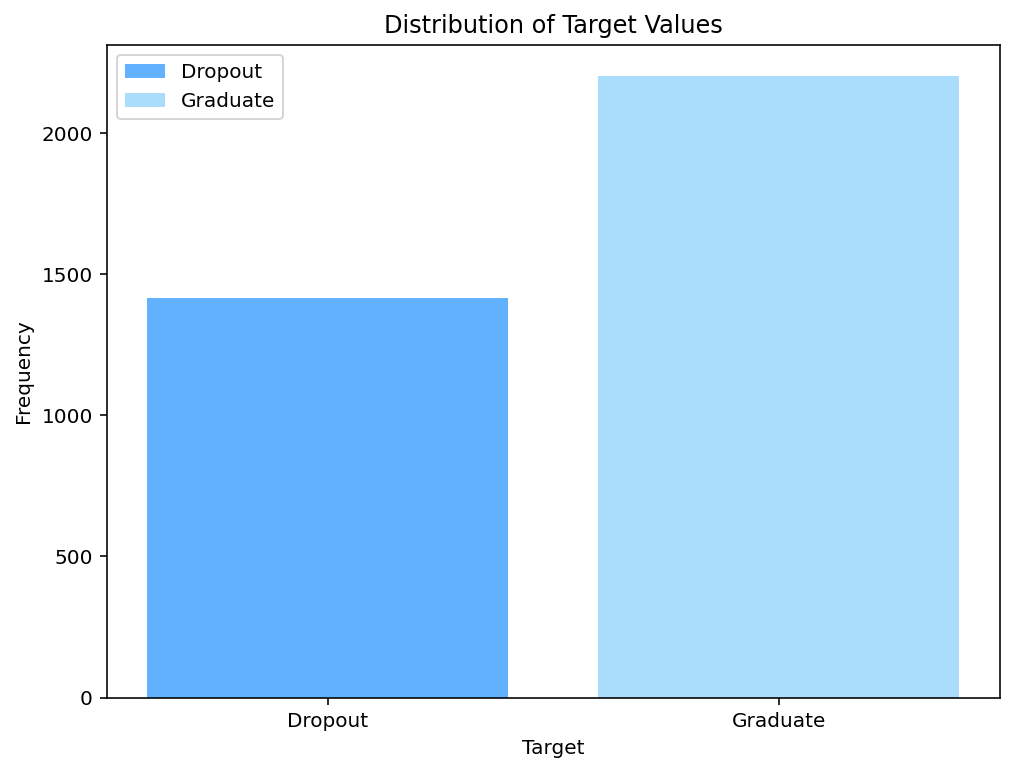

In [23]:
#Create plot for distribution of target values
dropout_counts = df['Target'].value_counts()['Dropout']
graduate_counts = df['Target'].value_counts()['Graduate']

plt.figure(figsize=(8, 6))
plt.title('Distribution of Target Values')
plt.xlabel('Target')
plt.ylabel('Frequency')

# Plot 'Dropout' category
plt.bar('Dropout', dropout_counts, color='dodgerblue', alpha=0.7, label='Dropout')

# Plot 'Graduate' category
plt.bar('Graduate', graduate_counts, color='lightskyblue', alpha=0.7, label='Graduate')

plt.legend()
plt.show()


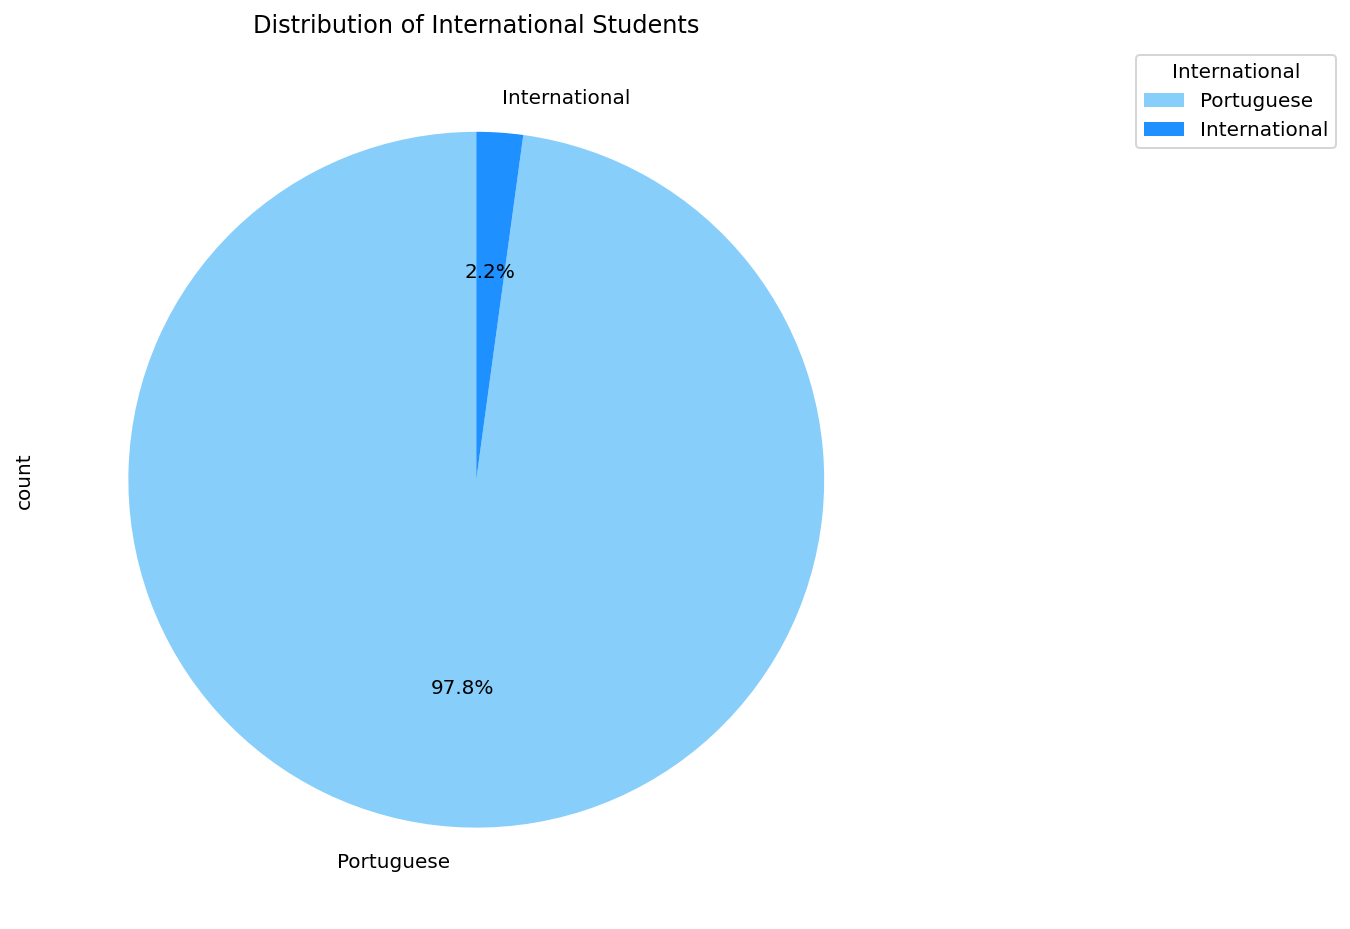

In [24]:
# Create pie chart for international and portugese students distribution
plt.figure(figsize=(8, 8))
international_counts = df['International'].value_counts()
international_counts.plot.pie(autopct='%1.1f%%', colors=['lightskyblue', 'dodgerblue'], labels=['Portuguese', 'International'], startangle=90)
plt.title('Distribution of International Students')
plt.legend(title='International', loc='upper right', bbox_to_anchor=(1, 0, 0.5, 1))  # Add legend
plt.show()

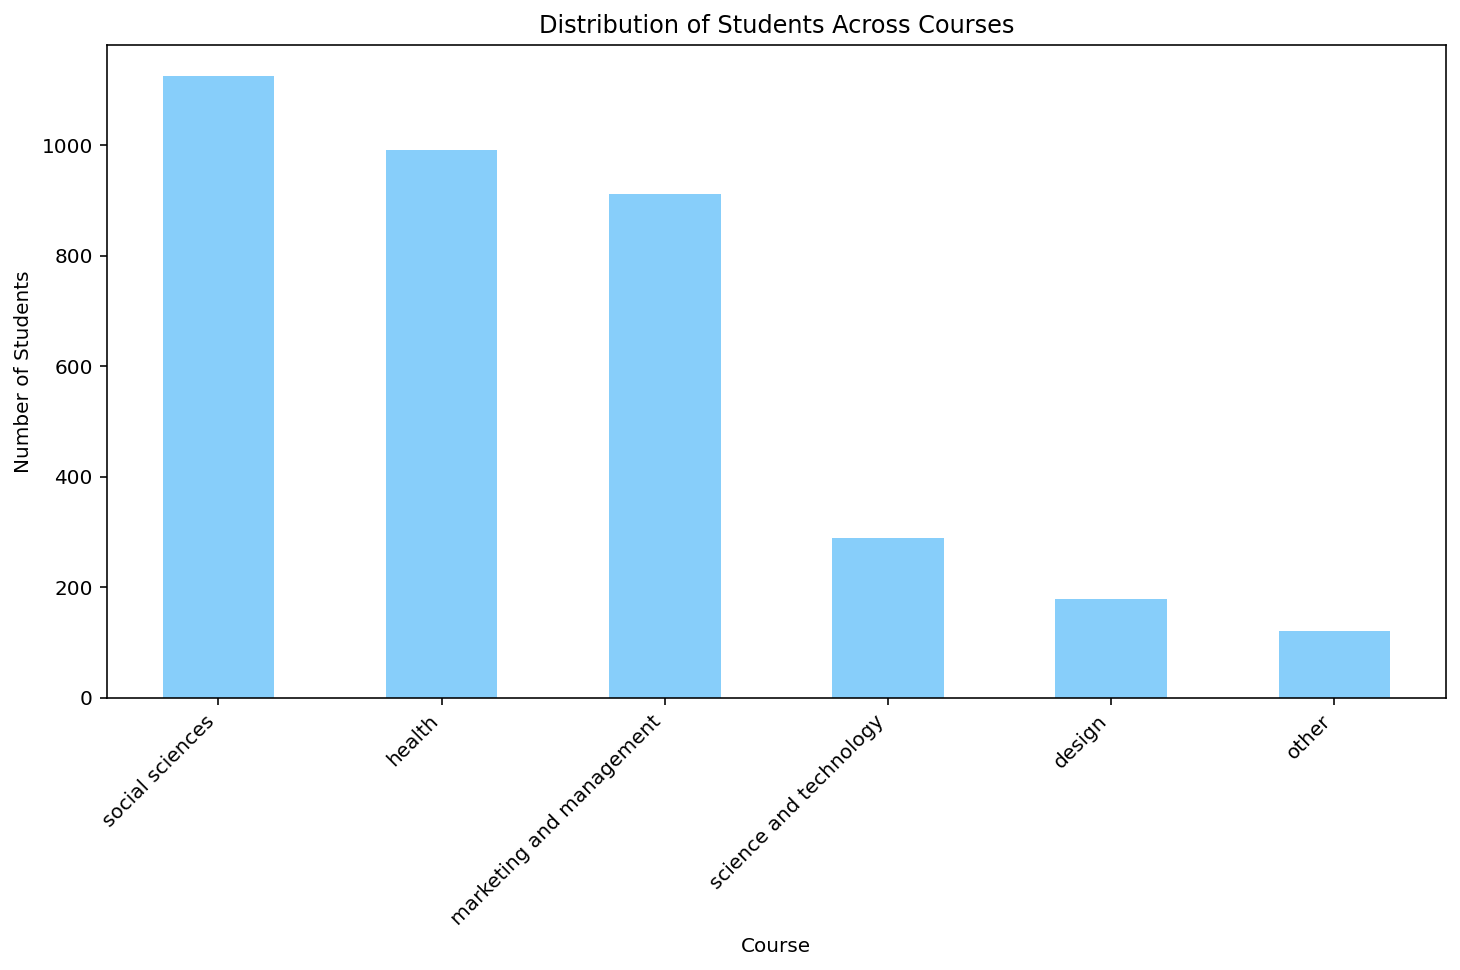

In [25]:
plt.figure(figsize=(12, 6))
course_counts = df['Course'].value_counts()
course_counts.plot(kind='bar', color='lightskyblue')
plt.title('Distribution of Students Across Courses')
plt.xlabel('Course')
plt.ylabel('Number of Students')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

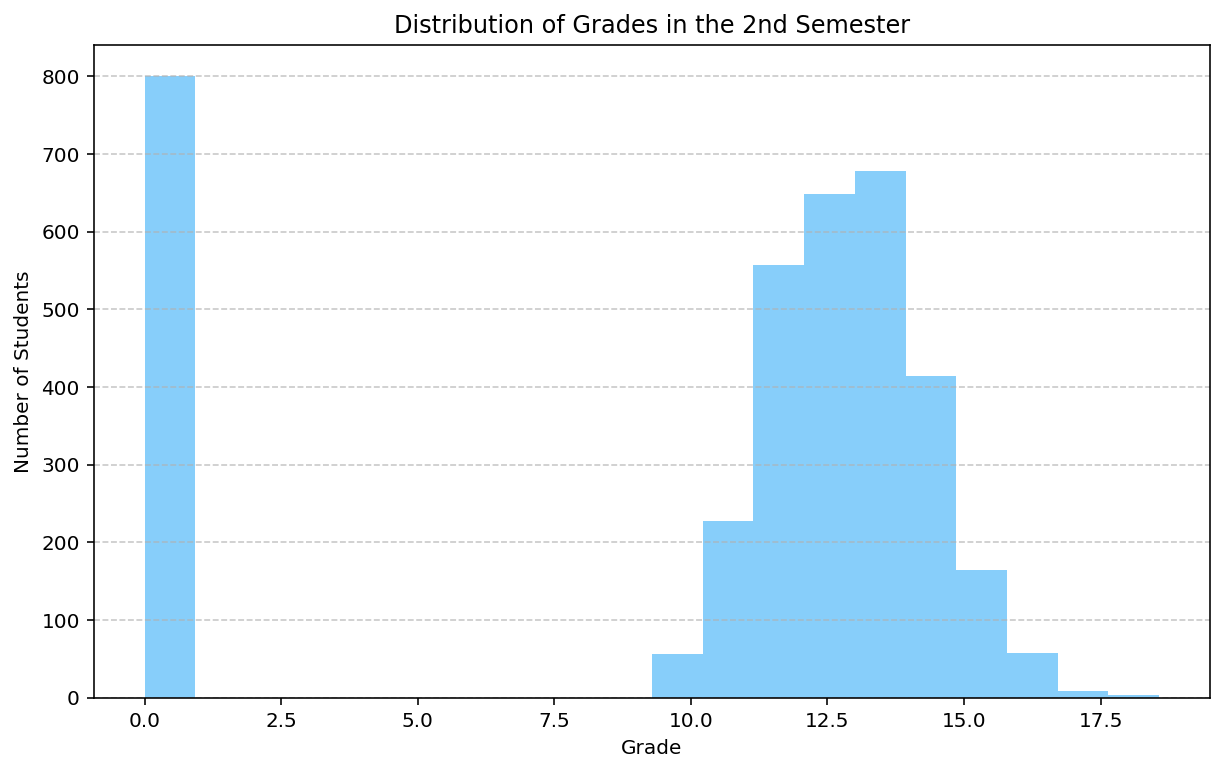

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(df['Curricular units 2nd sem (grade)'].dropna(), bins=20, color='lightskyblue')
plt.title('Distribution of Grades in the 2nd Semester')
plt.xlabel('Grade')
plt.ylabel('Number of Students')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Finding the Most Important Features



In [27]:
#CHI-SQUARE TEST TO FIND THE MOST IMPORTANT CATEGORICAL FEATURES


# List of categorical variable names
categorical_features = ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance',
                         'Previous qualification', "Mother's qualification",
                         "Father's qualification", "Mother's occupation", "Father's occupation",
                          'Debtor', 'Tuition fees up to date',
                         'Gender', 'Scholarship holder', 'International']

# Create a contingency table for each categorical feature and the target
contingency_tables = {}
for column in categorical_features:
    contingency_table = pd.crosstab(df[column], df['Target'])
    contingency_tables[column] = contingency_table

# Perform chi-squared test for each feature
chi2_results = {}
for column, contingency_table in contingency_tables.items():
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results[column] = {'chi2': chi2, 'p-value': p}

# Create a DataFrame with the results
chi2_df = pd.DataFrame.from_dict(chi2_results, orient='index')

# Sort the DataFrame by p-value in ascending order
chi2_df_sorted = chi2_df.sort_values('p-value')

# Select the top 5 features
top_5_features = chi2_df_sorted.head(5).index

# Display the top 5 features
print("\nTop 5 Most Significant Categorical Features by Chi-Square Test:")
print(top_5_features)


Top 5 Most Significant Categorical Features by Chi-Square Test:
Index(['Tuition fees up to date', 'Scholarship holder', 'Application mode',
       'Debtor', 'Course'],
      dtype='object')


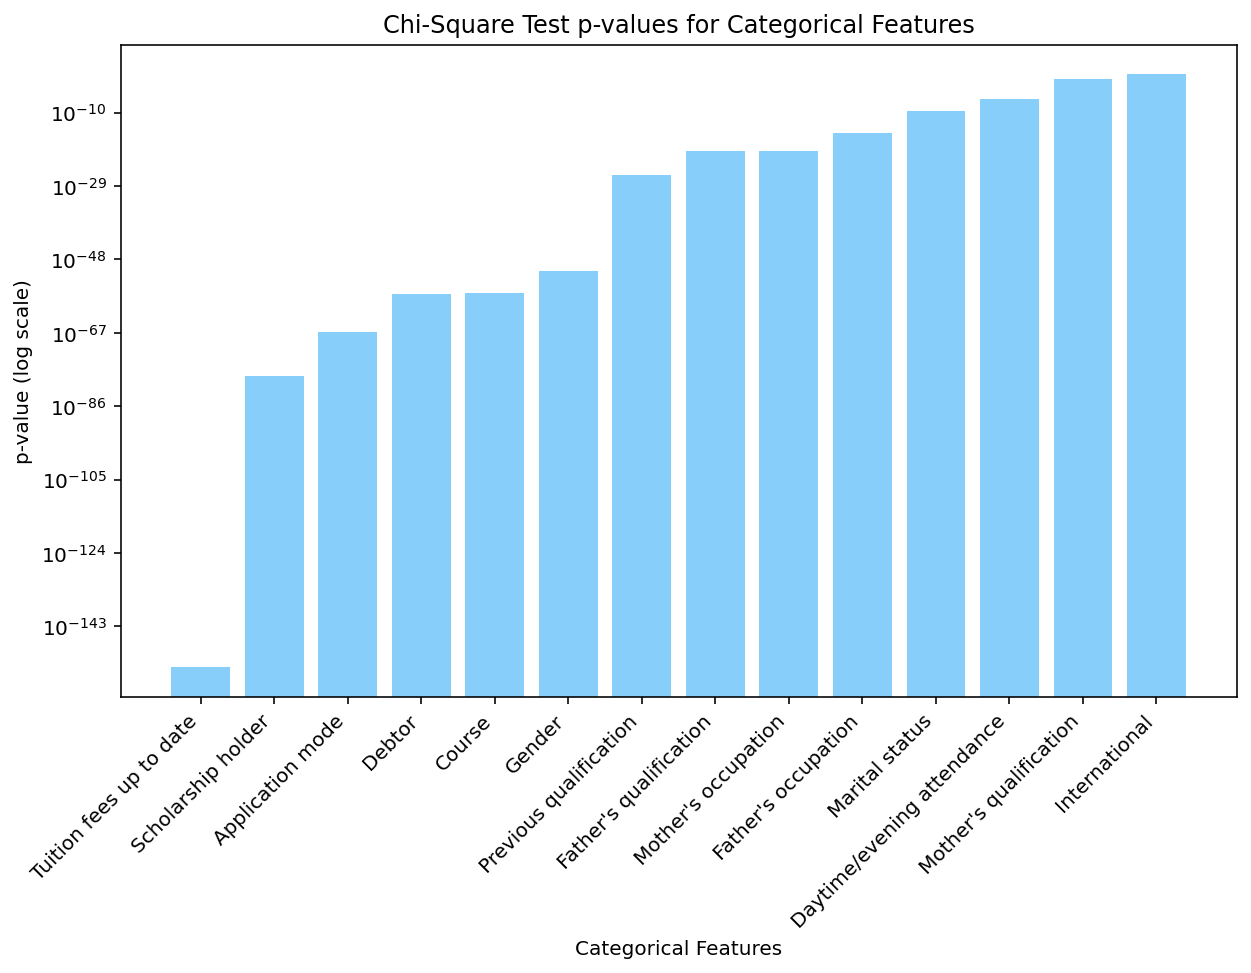

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(chi2_df_sorted.index, chi2_df_sorted['p-value'], color='lightskyblue')
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.xlabel('Categorical Features')
plt.ylabel('p-value (log scale)')
plt.title('Chi-Square Test p-values for Categorical Features')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [29]:
#ONE-HOT ENCODING CATEGORICAL VARIABLES AND TARGET

df_onehotencoded = pd.get_dummies(df, columns = ['Marital status', 'Application mode', 'Course', 'Previous qualification', 'Mother\'s qualification', 'Father\'s qualification', 'Mother\'s occupation', 'Father\'s occupation'])

df_onehotencoded['Target'] = df_onehotencoded['Target'].replace('Graduate', 1)
df_onehotencoded['Target'] = df_onehotencoded['Target'].replace('Dropout', 0)

In [30]:
#RANDOMFOREST'S FEATURE IMPORTANCES TO FIND THE MOST IMPORTANT NUMERIC FEATURES


# Extract the target variable
X = df_onehotencoded.drop('Target', axis=1) # Use all features except the target
y = df_onehotencoded['Target']

# Create and fit the Random Forest model
model_rf = RandomForestClassifier()
model_rf.fit(X, y)

# Get feature importances
feature_importances = model_rf.feature_importances_

# Create a DataFrame with feature names and importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort by importance
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_10_features_rf = importance_df_sorted.head(10)['Feature']

# Display the top 10 features from Random Forest
print("\nTop 10 Features from Random Forest:")
print(top_10_features_rf)


Top 10 Features from Random Forest:
14       Curricular units 2nd sem (approved)
15          Curricular units 2nd sem (grade)
10       Curricular units 1st sem (approved)
11          Curricular units 1st sem (grade)
3                    Tuition fees up to date
6                          Age at enrollment
13    Curricular units 2nd sem (evaluations)
9     Curricular units 1st sem (evaluations)
5                         Scholarship holder
8        Curricular units 1st sem (enrolled)
Name: Feature, dtype: object


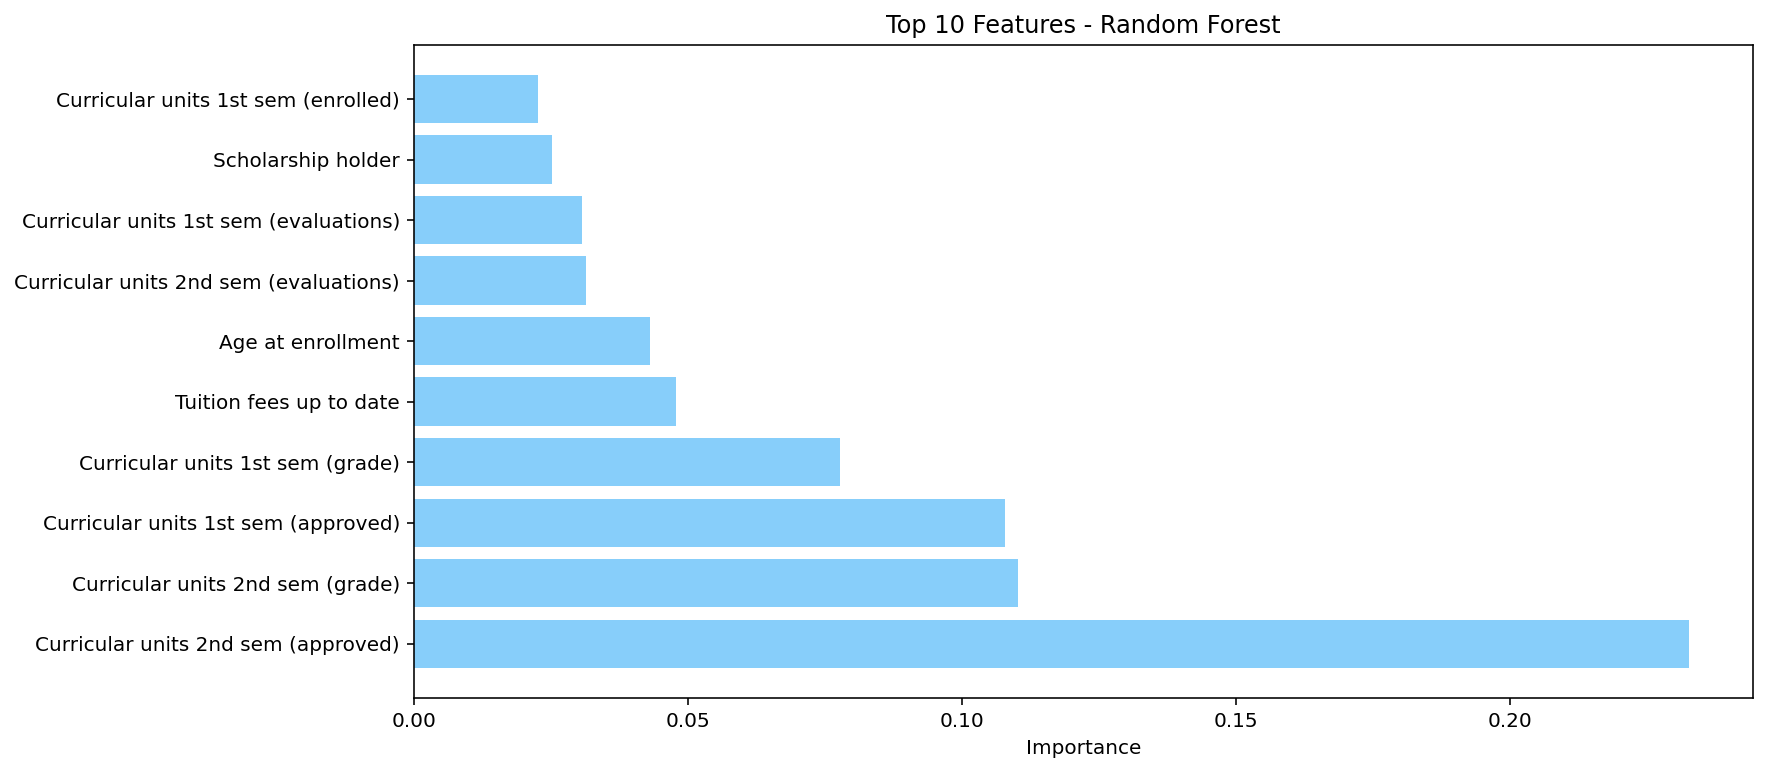

In [31]:
plt.figure(figsize=(12, 6))
plt.barh(importance_df_sorted['Feature'][:10], importance_df_sorted['Importance'][:10], color='lightskyblue')
plt.xlabel('Importance')
plt.title('Top 10 Features - Random Forest')
plt.show()

In [32]:
#USING LASSO REGRESSION TO FIND THE MOST IMPORTANT FEATURES OVERALL

X = df_onehotencoded.drop('Target', axis=1)  # Features
y = df_onehotencoded['Target']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Lasso regression model
lasso = Lasso(alpha=0.05)  # Adjust alpha as needed, default=0.1
lasso.fit(X_train_scaled, y_train)

# Extract coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})

# Display coefficients
print(coefficients.sort_values(by='Coefficient', ascending=False).head(10))

                                Feature  Coefficient
14  Curricular units 2nd sem (approved)     0.239893
3               Tuition fees up to date     0.064965
15     Curricular units 2nd sem (grade)     0.048817
5                    Scholarship holder     0.027561
25             Application mode_general     0.015309
0                     Application order     0.000000
50         Father's qualification_other    -0.000000
55  Mother's occupation_craft and trade    -0.000000
54         Mother's occupation_clerical     0.000000
53     Mother's occupation_armed forces     0.000000


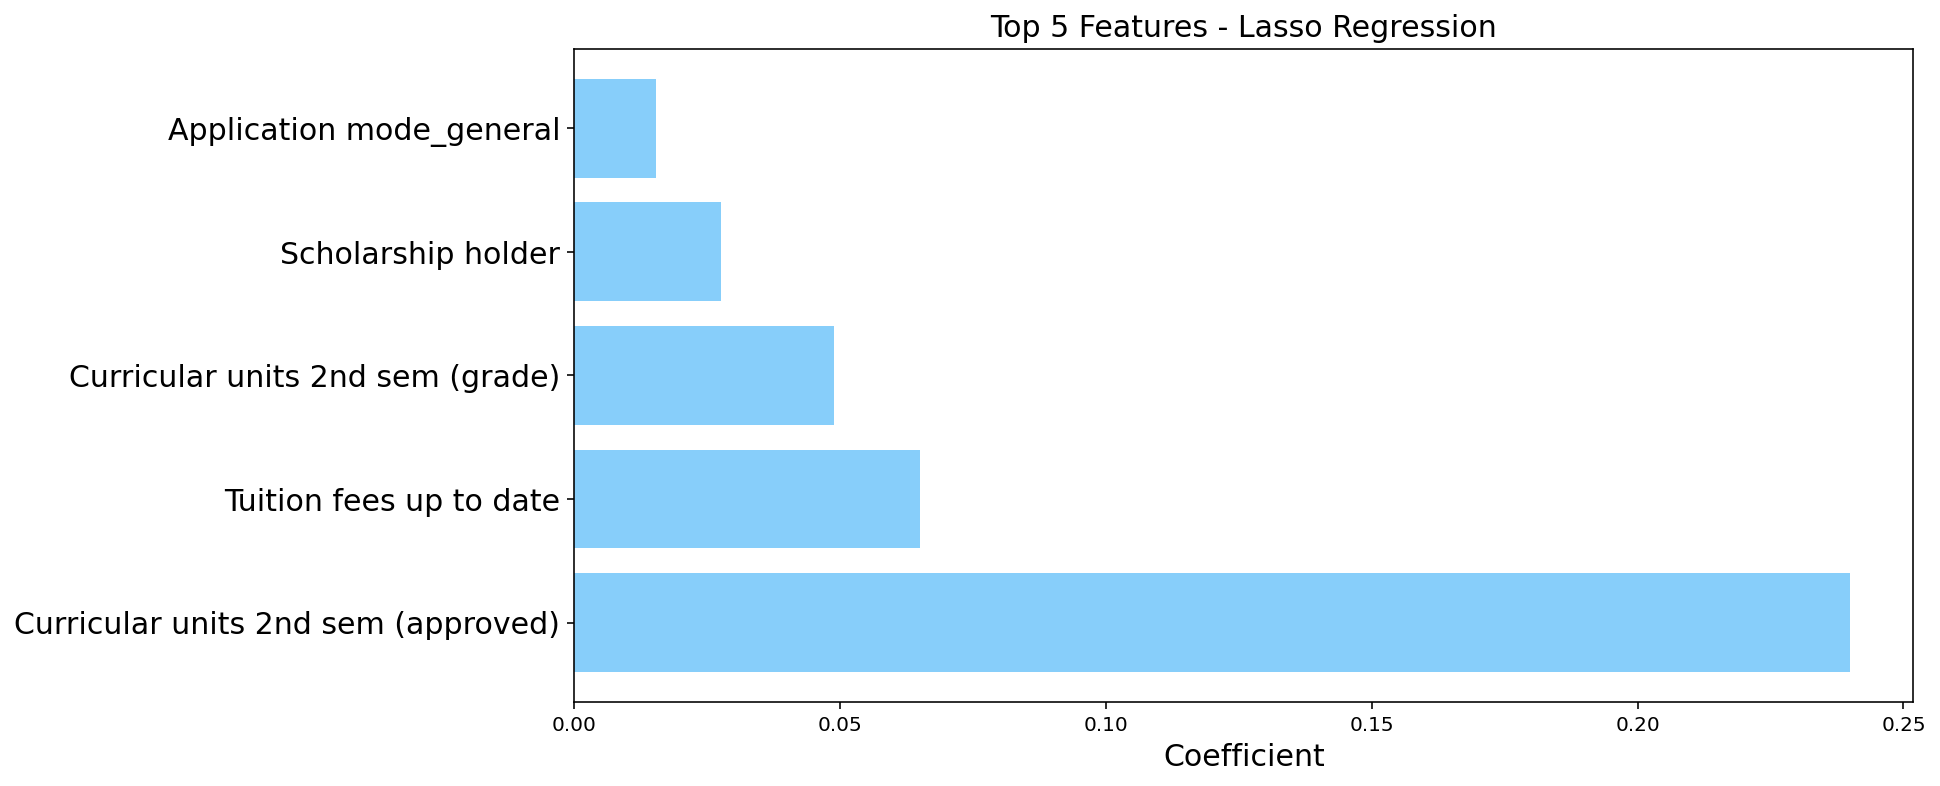

In [33]:
# Plot 10: Bar plot for sorted Lasso coefficients
sorted_coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

colors = 'lightskyblue'


plt.figure(figsize=(12, 6))
plt.barh(sorted_coefficients['Feature'][:5], sorted_coefficients['Coefficient'][:5], color=colors)
plt.xlabel('Coefficient', fontsize=15)
plt.title('Top 5 Features - Lasso Regression', fontsize=15)
plt.yticks(fontsize=15)

plt.show()


### Training and Evaluating Models for Predictions



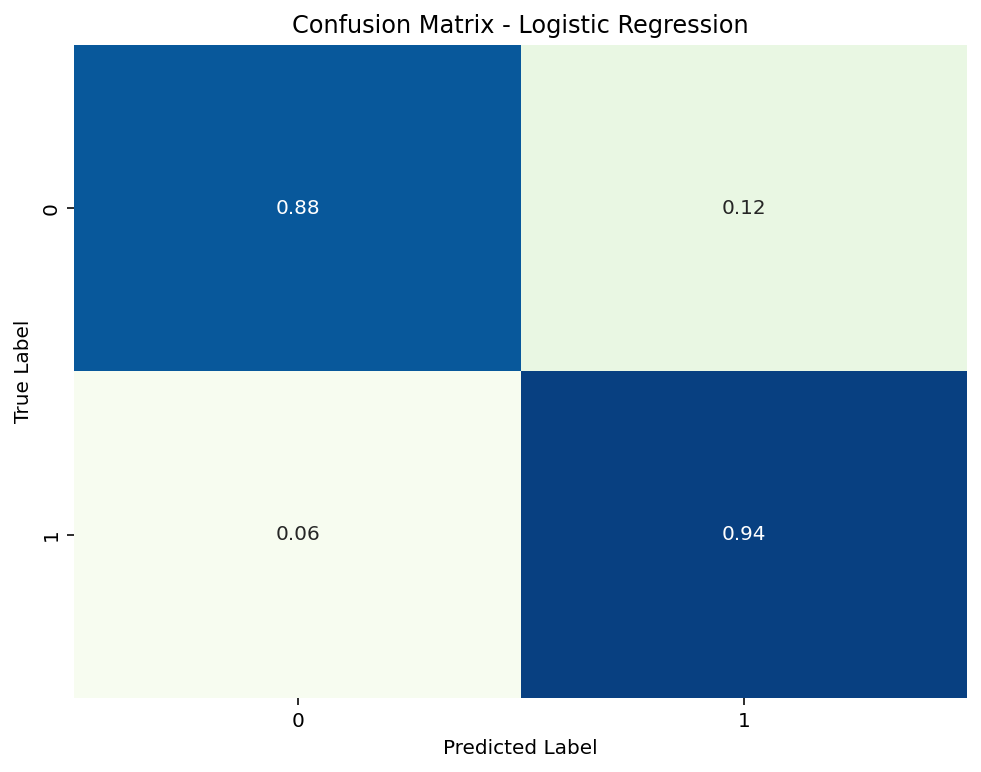

Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89       288
           1       0.92      0.94      0.93       435

    accuracy                           0.92       723
   macro avg       0.91      0.91      0.91       723
weighted avg       0.92      0.92      0.92       723



In [34]:
from sklearn.metrics import confusion_matrix

#LOGISTIC REGRESSION WITH ALL OF THE FEATURES

X = df_onehotencoded.drop('Target', axis=1)  # Features
y = df_onehotencoded['Target']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Create a logistic regression model
logistic_model = LogisticRegression(max_iter=1000)

# Fit the model to the training data
logistic_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report1 = classification_report(y_test, y_pred)


conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate percentages
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='GnBu', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report1)

In [35]:
#LOGISTIC REGRESSION WITH A SUBSET OF THE MOST IMPORTANT FEATURES

# Assuming 'X' is your original feature matrix
selected_features = ['Curricular units 2nd sem (approved)', 'Tuition fees up to date', 'Application mode_general',
                      'Curricular units 2nd sem (grade)', 'Scholarship holder', 'Curricular units 1st sem (grade)']

# Subset 'X' to include only the selected features
X_subset = X[selected_features]
y = df_onehotencoded['Target']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)

# Create a logistic regression model
logistic_model2 = LogisticRegression()

# Fit the model to the training data
logistic_model2.fit(X_train, y_train)

# Make predictions on the test data
y_pred2 = logistic_model2.predict(X_test)

# Evaluate the model
accuracy2 = accuracy_score(y_test, y_pred)
classification_report2 = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy2:.2f}")
print("Classification Report:\n", classification_report2)

Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89       288
           1       0.92      0.94      0.93       435

    accuracy                           0.92       723
   macro avg       0.91      0.91      0.91       723
weighted avg       0.92      0.92      0.92       723



In [36]:
#RANDOM FOREST WITH ALL OF THE FEATURES

X = df_onehotencoded.drop('Target', axis=1)  # Features
y = df_onehotencoded['Target']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
random_forest_model = RandomForestClassifier(n_estimators=300, random_state=42)

# Fit the model to the training data
random_forest_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = random_forest_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred)
classification_report_rf = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_rf:.2f}")
print("Classification Report:\n", classification_report_rf)

Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       288
           1       0.90      0.95      0.92       435

    accuracy                           0.91       723
   macro avg       0.91      0.90      0.90       723
weighted avg       0.91      0.91      0.91       723



In [37]:
#RANDOM FOREST WITH A SUBSET OF THE MOST IMPORTANT FEATURES

selected_features = ['Curricular units 2nd sem (approved)', 'Tuition fees up to date', 'Age at enrollment',
                      'Curricular units 2nd sem (grade)', 'Scholarship holder', 'Curricular units 1st sem (grade)',
                     'Curricular units 1st sem (evaluations)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 1st sem (approved)']

X_subset = X[selected_features]
y = df_onehotencoded['Target']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier
random_forest_model2 = RandomForestClassifier(n_estimators=300, random_state=42)

# Fit the model to the training data
random_forest_model2.fit(X_train, y_train)

# Make predictions on the test data
y_pred2 = random_forest_model2.predict(X_test)

# Evaluate the model
accuracy_rf2 = accuracy_score(y_test, y_pred)
classification_report_rf2 = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_rf2:.2f}")
print("Classification Report:\n", classification_report_rf2)

Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       288
           1       0.90      0.95      0.92       435

    accuracy                           0.91       723
   macro avg       0.91      0.90      0.90       723
weighted avg       0.91      0.91      0.91       723



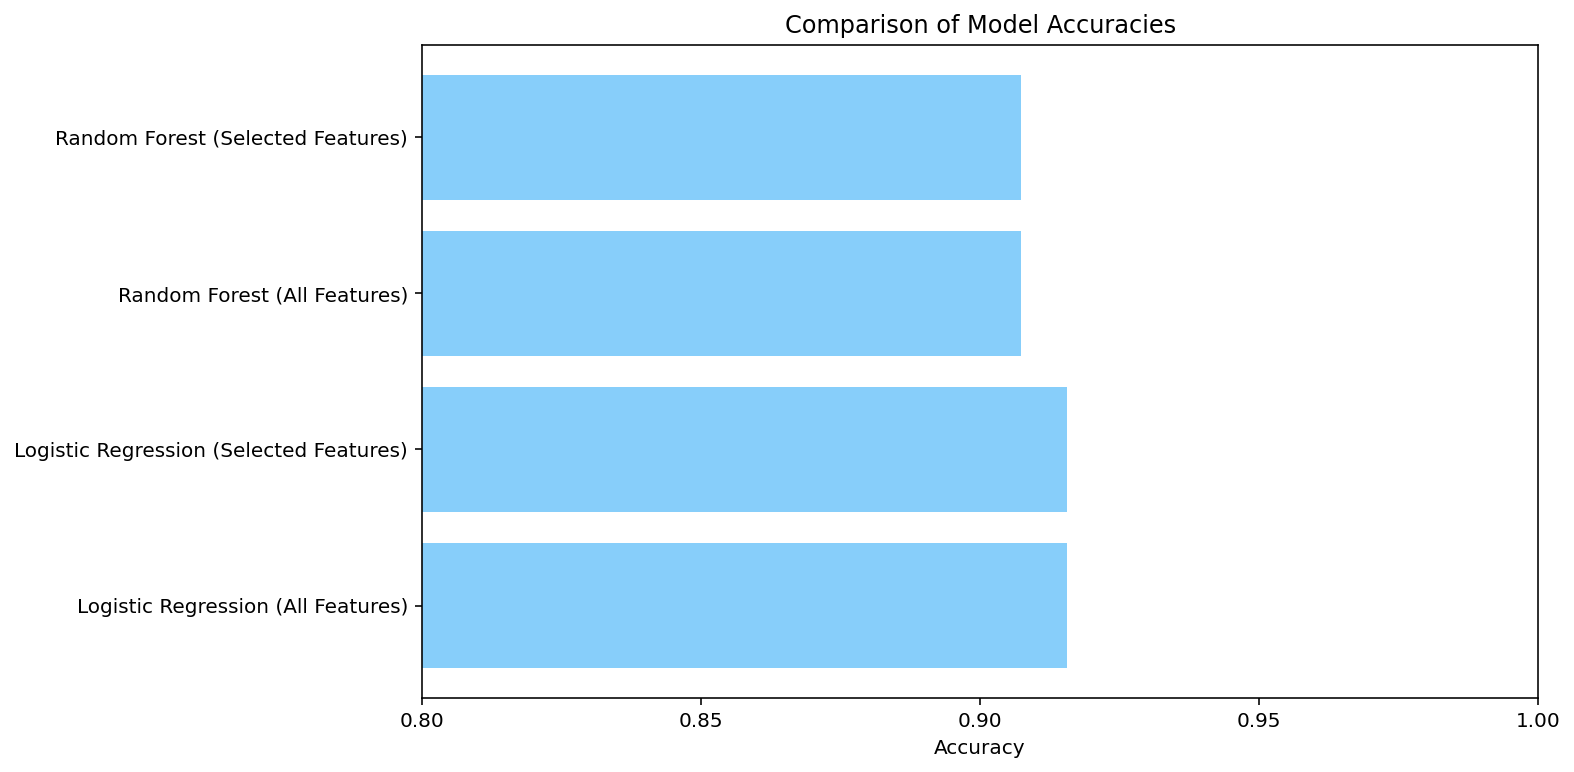

In [38]:

# Accuracy values for each model
model_accuracies = [accuracy, accuracy2, accuracy_rf, accuracy_rf2]

# Model names
model_names = ['Logistic Regression (All Features)', 'Logistic Regression (Selected Features)',
               'Random Forest (All Features)', 'Random Forest (Selected Features)']

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(model_names, model_accuracies, color='lightskyblue')
plt.xlabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xlim(0.8, 1.0)  # Set the x-axis limit from 0.8 to 1.0 for better comparison
plt.xticks([0.8, 0.85, 0.9, 0.95, 1.0])


plt.show()